In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.calibration import calibration_curve

import xgboost as xgb

Explore the credit data

Begin by looking at the data set cr_loan. In this data set, loan_status shows whether the loan is currently in default with 1 being default and 0 being non-default.

You have more columns within the data, and many could have a relationship with the values in loan_status. You need to explore the data and these relationships more with further analysis to understand the impact of the data on credit loan defaults.

Checking the structure of the data as well as seeing a snapshot helps us better understand what's inside the set. Similarly, visualizations provide a high level view of the data in addition to important trends and patterns.

In [2]:
cr_loan = pd.read_csv('cr_loan2.csv')
cr_loan

person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
...           ...            ...                   ...                ...   
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0             PERSONAL          D      35000          16.02            1   
1            EDUCATION          B       1000          11.14            0   
2              MEDICAL          C       5500          12.87            1   
3              MEDICAL          C      35000          15.23            1   
4              MEDICAL          C      35000          14.27            1   
...                ...        ...        ...            ...          ...   
32576         PERSONAL          C       5800          13.16            0   
32577         PERSONAL          A      17625           7.49            0   
32578  HOMEIMPROVEMENT          B      35000          10.99            1   
32579         PERSONAL          B      15000          11.48            0   
32580          MEDICAL          B       6475           9.99            0   

       loan_percent_income cb_person_default_on_file  \
0                     0.59                         Y   
1                     0.10                         N   
2                     0.57                         N   
3                     0.53                         N   
4                     0.55                         Y   
...                    ...                       ...   
32576                 0.11                         N   
32577                 0.15                         N   
32578                 0.46                         N   
32579                 0.10                         N   
32580                 0.15                         N   

       cb_person_cred_hist_length  
0                               3  
1                               2  
2                               3  
3                               2  
4                               4  
...                           ...  
32576                          30  
32577                          19  
32578                          28  
32579                          26  
32580                          30  

[32581 rows x 12 columns]

In [3]:
cr_loan.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

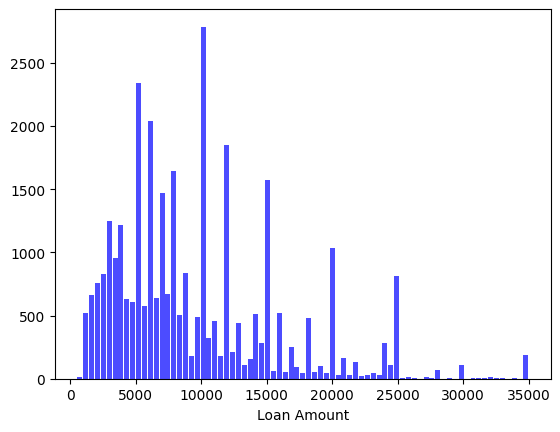

(array([1.100e+01, 5.180e+02, 6.660e+02, 7.600e+02, 8.250e+02, 1.250e+03,
        9.560e+02, 1.220e+03, 6.310e+02, 6.090e+02, 2.339e+03, 5.790e+02,
        2.037e+03, 6.350e+02, 1.473e+03, 6.700e+02, 1.643e+03, 5.020e+02,
        8.380e+02, 1.770e+02, 4.900e+02, 2.785e+03, 3.240e+02, 4.590e+02,
        1.780e+02, 1.850e+03, 2.150e+02, 4.380e+02, 1.080e+02, 1.540e+02,
        5.160e+02, 2.830e+02, 1.569e+03, 6.400e+01, 5.190e+02, 5.300e+01,
        2.510e+02, 9.000e+01, 4.300e+01, 4.790e+02, 5.300e+01, 1.040e+02,
        4.700e+01, 1.036e+03, 3.100e+01, 1.630e+02, 2.800e+01, 1.360e+02,
        1.800e+01, 2.900e+01, 4.700e+01, 2.900e+01, 2.830e+02, 1.070e+02,
        8.120e+02, 6.000e+00, 1.700e+01, 2.000e+00, 1.000e+00, 1.200e+01,
        8.000e+00, 6.800e+01, 0.000e+00, 7.000e+00, 1.000e+00, 1.090e+02,
        0.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 1.000e+01, 2.000e+00,
        6.000e+00, 1.000e+00, 6.000e+00, 0.000e+00, 1.860e+02]),
 array([  500.        ,   948.05194805,  1396.1

In [4]:
# Look at the distribution of loan amounts with a histogram
n, bins, patches = plt.hist(x=cr_loan['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()

n, bins, patches

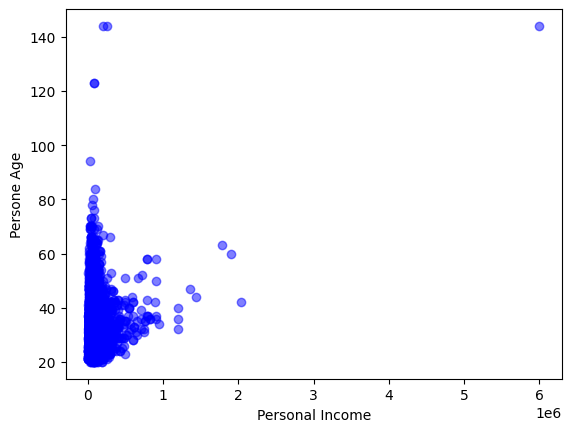

In [5]:
# Plot a scatter plot of income against age
plt.scatter(cr_loan['person_income'], cr_loan['person_age'],c='blue', alpha=0.5)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.show()

Crosstab and pivot tables

Often, financial data is viewed as a pivot table in spreadsheets like Excel.

With cross tables, you get a high level view of selected columns and even aggregation like a count or average. For most credit risk models, especially for probability of default, columns like person_emp_length and person_home_ownership are common to begin investigating.

You will be able to see how the values are populated throughout the data, and visualize them. For now, you need to check how loan_status is affected by factors like home ownership status, loan grade, and loan percentage of income.

In [6]:
# Create a cross table of the loan intent and loan status
pd.crosstab(cr_loan['loan_intent'], cr_loan['loan_status'], margins = True)

loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5342  1111   6453
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4423  1098   5521
VENTURE             4872   847   5719
All                25473  7108  32581

In [7]:
# Create a cross table of home ownership, loan status, and grade
pd.crosstab(cr_loan['person_home_ownership'],[cr_loan['loan_status'],cr_loan['loan_grade']])

loan_status               0                                 1             \
loan_grade                A     B     C    D    E   F  G    A     B    C   
person_home_ownership                                                      
MORTGAGE               5219  3729  1934  658  178  36  0  239   324  321   
OTHER                    23    29    11    9    2   0  0    3     5    6   
OWN                     860   770   464  264   26   7  0   66    34   31   
RENT                   3602  4222  2710  554  137  28  1  765  1338  981   

loan_status                               
loan_grade                D    E   F   G  
person_home_ownership                     
MORTGAGE                553  161  61  31  
OTHER                    11    6   2   0  
OWN                      18   31   8   5  
RENT                   1559  423  99  27

In [8]:
# Create a cross table of home ownership, loan status, and average percent income
pd.crosstab(cr_loan['person_home_ownership'], cr_loan['loan_status'],
              values=cr_loan['loan_percent_income'], aggfunc='mean')

loan_status                   0         1
person_home_ownership                    
MORTGAGE               0.146504  0.184882
OTHER                  0.143784  0.300000
OWN                    0.180013  0.297358
RENT                   0.144611  0.264859

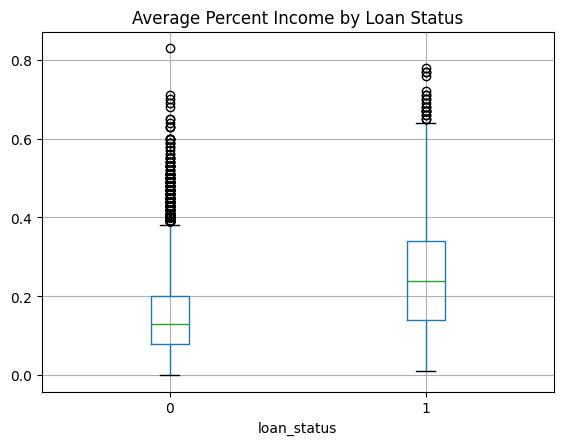

In [9]:
# Create a box plot of percentage income by loan status
cr_loan.boxplot(column = ['loan_percent_income'], by = 'loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

# It looks like the average percentage of income for defaults is higher. This could indicate those recipients have a debt-to-income ratio that's already too high.

Finding outliers with cross tables

Now you need to find and remove outliers you suspect might be in the data. For this exercise, you can use cross tables and aggregate functions.

Have a look at the person_emp_length column. You've used the aggfunc = 'mean' argument to see the average of a numeric column before, but to detect outliers you can use other functions like min and max.

It may not be possible for a person to have an employment length of less than 0 or greater than 60. You can use cross tables to check the data and see if there are any instances of this!

In [10]:
# Create the cross table for loan status, home ownership, and the max employment length
pd.crosstab(cr_loan['loan_status'],cr_loan['person_home_ownership'],
                  values=cr_loan['person_emp_length'], aggfunc='max')

person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         123.0   24.0  31.0   41.0
1                          34.0   11.0  17.0  123.0

In [11]:
# Create an array of indices where employment length is greater than 60
indices = cr_loan[cr_loan['person_emp_length'] > 60].index

print(cr_loan.shape)

# Drop the records from the data based on the indices and create a new dataframe
cr_loan.drop(indices, inplace=True)

print(cr_loan.shape)

(32581, 12)
(32579, 12)


In [12]:
# Create an array of indices where employment length is greater than 60
indices = cr_loan[cr_loan['person_emp_length'] > 60].index

print(cr_loan.shape)

# Drop the records from the data based on the indices and create a new dataframe
cr_loan.drop(indices, inplace=True)

print(cr_loan.shape)

(32579, 12)
(32579, 12)


In [13]:
# Create the cross table from earlier and include minimum employment length
pd.crosstab(cr_loan['loan_status'],cr_loan['person_home_ownership'],
            values=cr_loan['person_emp_length'], aggfunc=['min','max'])

min                      max                  
person_home_ownership MORTGAGE OTHER  OWN RENT MORTGAGE OTHER   OWN  RENT
loan_status                                                              
0                          0.0   0.0  0.0  0.0     38.0  24.0  31.0  41.0
1                          0.0   0.0  0.0  0.0     34.0  11.0  17.0  27.0

Visualizing credit outliers

You discovered outliers in person_emp_length where values greater than 60 were far above the norm. person_age is another column in which a person can use a common sense approach to say it is very unlikely that a person applying for a loan will be over 100 years old.

Visualizing the data here can be another easy way to detect outliers. You can use other numeric columns like loan_amnt and loan_int_rate to create plots with person_age to search for outliers.

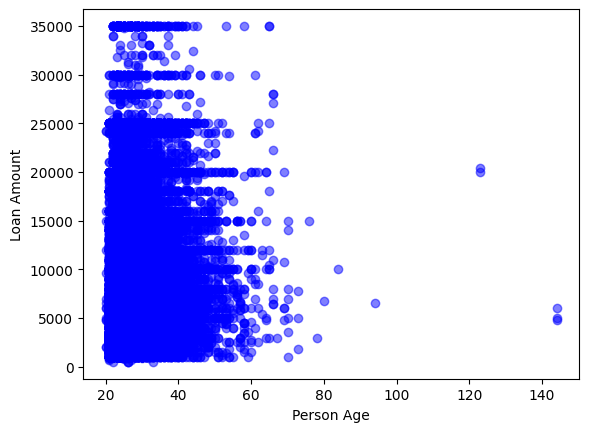

In [14]:
# Create the scatter plot for age and amount
plt.scatter(cr_loan['person_age'], cr_loan['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()

In [15]:
# Create an array of indices where person age > 120
indices = cr_loan[cr_loan['person_age'] > 120].index

print(cr_loan.shape)

# Drop the records from the data based on the indices and create a new dataframe
cr_loan.drop(indices, inplace=True)

print(cr_loan.shape)

(32579, 12)
(32574, 12)


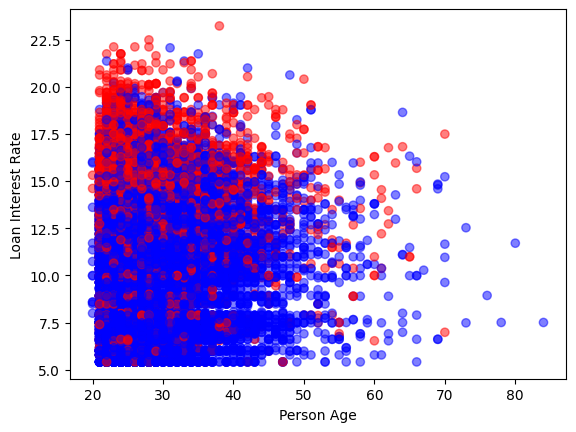

In [16]:
# Use Pandas to drop the record from the data frame and create a new one
cr_loan.drop(cr_loan[cr_loan['person_age'] > 100].index, inplace=True)

# Create a scatter plot of age and interest rate
colors = ["blue","red"]
plt.scatter(cr_loan['person_age'], cr_loan['loan_int_rate'],
            c = cr_loan['loan_status'],
            cmap = matplotlib.colors.ListedColormap(colors),
            alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

# we have loan_status as a label for colors. This shows a different color depending on the class. 
# In this case, it's loan default and non-default, and it looks like there are more defaults with high interest rates.

Replacing missing credit data

Now, you should check for missing data. If you find missing data within loan_status, you would not be able to use the data for predicting probability of default because you wouldn't know if the loan was a default or not. Missing data within person_emp_length would not be as damaging, but would still cause training errors.

So, check for missing data in the person_emp_length column and replace any missing values with the median.

In [17]:
cr_loan

person_age  person_income person_home_ownership  person_emp_length  \
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
5              21           9900                   OWN                2.0   
...           ...            ...                   ...                ...   
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
1            EDUCATION          B       1000          11.14            0   
2              MEDICAL          C       5500          12.87            1   
3              MEDICAL          C      35000          15.23            1   
4              MEDICAL          C      35000          14.27            1   
5              VENTURE          A       2500           7.14            1   
...                ...        ...        ...            ...          ...   
32576         PERSONAL          C       5800          13.16            0   
32577         PERSONAL          A      17625           7.49            0   
32578  HOMEIMPROVEMENT          B      35000          10.99            1   
32579         PERSONAL          B      15000          11.48            0   
32580          MEDICAL          B       6475           9.99            0   

       loan_percent_income cb_person_default_on_file  \
1                     0.10                         N   
2                     0.57                         N   
3                     0.53                         N   
4                     0.55                         Y   
5                     0.25                         N   
...                    ...                       ...   
32576                 0.11                         N   
32577                 0.15                         N   
32578                 0.46                         N   
32579                 0.10                         N   
32580                 0.15                         N   

       cb_person_cred_hist_length  
1                               2  
2                               3  
3                               2  
4                               4  
5                               2  
...                           ...  
32576                          30  
32577                          19  
32578                          28  
32579                          26  
32580                          30  

[32574 rows x 12 columns]

In [18]:
# Print a null value column array
cr_loan.columns[cr_loan.isnull().any()]

Index(['person_emp_length', 'loan_int_rate'], dtype='object')

In [19]:
# Print all rows with nulls for employment length
cr_loan[cr_loan['person_emp_length'].isnull()]

person_age  person_income person_home_ownership  person_emp_length  \
105            22          12600              MORTGAGE                NaN   
222            24         185000              MORTGAGE                NaN   
379            24          16800              MORTGAGE                NaN   
407            25          52000                  RENT                NaN   
408            22          17352              MORTGAGE                NaN   
...           ...            ...                   ...                ...   
32285          38          12000                   OWN                NaN   
32328          51          18408                  RENT                NaN   
32360          70          39996                  RENT                NaN   
32453          56          32400                  RENT                NaN   
32471          53          54000                  RENT                NaN   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
105             PERSONAL          A       2000           5.42            1   
222            EDUCATION          B      35000          12.42            0   
379    DEBTCONSOLIDATION          A       3900            NaN            1   
407             PERSONAL          B      24000          10.74            1   
408            EDUCATION          C       2250          15.27            0   
...                  ...        ...        ...            ...          ...   
32285          EDUCATION          A       4800           7.29            1   
32328           PERSONAL          C       1000          14.65            1   
32360            MEDICAL          C       3600          15.23            0   
32453            MEDICAL          A       8575           7.51            0   
32471            MEDICAL          D      10000          14.59            1   

       loan_percent_income cb_person_default_on_file  \
105                   0.16                         N   
222                   0.19                         N   
379                   0.23                         N   
407                   0.46                         N   
408                   0.13                         Y   
...                    ...                       ...   
32285                 0.40                         N   
32328                 0.05                         Y   
32360                 0.09                         Y   
32453                 0.26                         N   
32471                 0.19                         Y   

       cb_person_cred_hist_length  
105                             4  
222                             2  
379                             3  
407                             2  
408                             3  
...                           ...  
32285                          12  
32328                          20  
32360                          19  
32453                          18  
32471                          27  

[895 rows x 12 columns]

In [20]:
# Impute the null values with the median value for all employment lengths
cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)

cr_loan[cr_loan['person_emp_length'].isnull()]

C:\Users\Alienware\AppData\Local\Temp\ipykernel_11016\18078800.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)


Empty DataFrame
Columns: [person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_status, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length]
Index: []

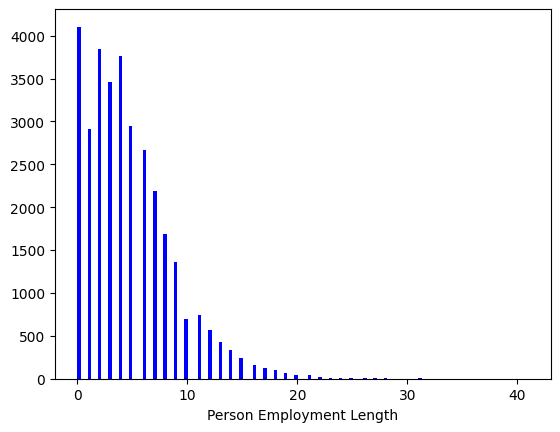

In [21]:
# Create a histogram of employment length
n, bins, patches = plt.hist(cr_loan['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

Removing missing data

You replaced missing data in person_emp_length, but in the previous exercise you saw that loan_int_rate has missing data as well.

Similar to having missing data within loan_status, having missing data within loan_int_rate will make predictions difficult.

Because interest rates are set by your company, having missing data in this column is very strange. It's possible that data ingestion issues created errors, but you cannot know for sure. For now, it's best to .drop() these records before moving forward.

In [22]:
# Print the number of nulls
cr_loan['loan_int_rate'].isnull().sum()

3115

In [23]:
# Store the array on indices
indices = cr_loan[cr_loan['loan_int_rate'].isnull()].index

# Save the new data without missing data
cr_loan.drop(indices, inplace=True)

cr_loan['loan_int_rate'].isnull().sum()

0

In [24]:
# Count the number of records for each unique value
cr_loan['person_home_ownership'].value_counts(dropna=False)

person_home_ownership
RENT        14890
MORTGAGE    12119
OWN          2356
OTHER          94
Name: count, dtype: int64

Logistic regression basics

You've now cleaned up the data and created the new data set cr_loan.

Think back to the final scatter plot which showed more defaults with high loan_int_rate. Interest rates are easy to understand, but what how useful are they for predicting the probability of default?

Since you haven't tried predicting the probability of default yet, test out creating and training a logistic regression model with just loan_int_rate. Also check the model's internal parameters, which are like settings, to see the structure of the model with this one column.

In [25]:
# Create the X and y data sets
X = cr_loan[['loan_int_rate']]
y = cr_loan['loan_status']

In [26]:
# Create and fit a logistic regression model
clf_logistic_single = LogisticRegression()
clf_logistic_single.fit(X, y)

LogisticRegression()

In [27]:
# Print the parameters of the model
print(clf_logistic_single.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [28]:
# Print the coefficient of the model
print(clf_logistic_single.coef_)
# The change in log-odds of loan status (e.g., insolvency) for a unit increase in loan interest rate

# Print the exponential of the coefficient
print(np.exp(clf_logistic_single.coef_))
# The odds ratio for a unit increase in loan interest rate
# As the odds ratio is greater than one, it means that the probability of insolvency increases with a higher interest rate

# Print the intercept of the model
print(clf_logistic_single.intercept_)
# The log-odds of loan status (e.g., insolvency) when the loan interest rate is zero

# Print the exponential of the intercept
print(np.exp(clf_logistic_single.intercept_))
# The baseline odds of loan status when the loan interest rate is zero
# As the baseline odds are lower than one, it means that the probability of insolvency is low when interest rates are zero


[[0.27144136]]
[[1.31185394]]
[-4.45784525]
[0.0115873]


Multivariate logistic regression

Generally, you won't use only loan_int_rate to predict the probability of default. You will want to use all the data you have to make predictions.

With this in mind, try training a new model with different columns, called features, from the cr_loan_clean data. Will this model differ from the first one? For this, you can easily check the .intercept_ of the logistic regression. Remember that this is the y-intercept of the function and the overall log-odds of non-default.

In [29]:
# Create X data for the model
X_multi = cr_loan[['loan_int_rate','person_emp_length']]

# Create a set of y data for training
y = cr_loan['loan_status']

# Create and train a new logistic regression
clf_logistic_multi = LogisticRegression(solver='lbfgs').fit(X_multi, y)

# Print the intercept of the model
print(clf_logistic_multi.intercept_, np.exp(clf_logistic_multi.intercept_)) # still very low, but slightly higher, baseline insolvency probability

[-4.21644963] [0.01475092]


Creating training and test sets

You've just trained LogisticRegression() models on different columns.

You know that the data should be separated into training and test sets. test_train_split() is used to create both at the same time. The training set is used to make predictions, while the test set is used for evaluation. Without evaluating the model, you have no way to tell how well it will perform on new loan data.

In [30]:
# Create the X and y data sets
X = cr_loan[['loan_int_rate','person_emp_length','person_income']]
y = cr_loan['loan_status']

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=333)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf_logistic = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train_scaled, y_train)

# Print the models coefficients
print(clf_logistic.coef_)
print(np.exp(clf_logistic.coef_))

[[ 0.9334988  -0.07822411 -1.11644385]]
[[2.54339246 0.92475716 0.32744216]]


Changing coefficients

With this understanding of the coefficients of a LogisticRegression() model, have a closer look at them to see how they change depending on what columns are used for training. Will the column coefficients change from model to model?

You should .fit() two different LogisticRegression() models on different groups of columns to check. You should also consider what the potential impact on the probability of default might be.

In [31]:
# Create the X and y data sets
X1 = cr_loan[['loan_amnt','person_emp_length','person_income']]
y = cr_loan['loan_status']

# Use test_train_split to create the training and test sets
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=.3, random_state=333)

scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

clf_logistic1 = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X1_train_scaled, y_train)

# Print the models coefficients
print(clf_logistic1.coef_)
print(np.exp(clf_logistic1.coef_))

[[ 0.72817658 -0.14004865 -1.73477679]]
[[2.07130031 0.86931594 0.17643958]]


In [32]:
# Create the X and y data sets
X2 = cr_loan[['cb_person_cred_hist_length','loan_percent_income','person_income']]
y = cr_loan['loan_status']

# Use test_train_split to create the training and test sets
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.3, random_state=333)

scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

clf_logistic2 = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X2_train_scaled, y_train)

# Print the models coefficients
print(clf_logistic2.coef_)
print(np.exp(clf_logistic2.coef_))

[[ 0.0144473   0.78380233 -0.58668742]]
[[1.01455217 2.18978274 0.55616658]]


One-hot encoding credit data

It's time to prepare the non-numeric columns so they can be added to your LogisticRegression() model.

Once the new columns have been created using one-hot encoding, you can concatenate them with the numeric columns to create a new data frame which will be used throughout the rest of the course for predicting probability of default.

Remember to only one-hot encode the non-numeric columns. Doing this to the numeric columns would create an incredibly wide data set!

In [33]:
# Create two data sets for numeric and non-numeric data
cred_num = cr_loan.select_dtypes(exclude=['object'])
cred_str = cr_loan.select_dtypes(include=['object'])
cred_str

person_home_ownership      loan_intent loan_grade  \
1                       OWN        EDUCATION          B   
2                  MORTGAGE          MEDICAL          C   
3                      RENT          MEDICAL          C   
4                      RENT          MEDICAL          C   
5                       OWN          VENTURE          A   
...                     ...              ...        ...   
32576              MORTGAGE         PERSONAL          C   
32577              MORTGAGE         PERSONAL          A   
32578                  RENT  HOMEIMPROVEMENT          B   
32579              MORTGAGE         PERSONAL          B   
32580                  RENT          MEDICAL          B   

      cb_person_default_on_file  
1                             N  
2                             N  
3                             N  
4                             Y  
5                             N  
...                         ...  
32576                         N  
32577                         N  
32578                         N  
32579                         N  
32580                         N  

[29459 rows x 4 columns]

In [34]:
# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)
cred_str_onehot

person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
1                               False                        False   
2                                True                        False   
3                               False                        False   
4                               False                        False   
5                               False                        False   
...                               ...                          ...   
32576                            True                        False   
32577                            True                        False   
32578                           False                        False   
32579                            True                        False   
32580                           False                        False   

       person_home_ownership_OWN  person_home_ownership_RENT  \
1                           True                       False   
2                          False                       False   
3                          False                        True   
4                          False                        True   
5                           True                       False   
...                          ...                         ...   
32576                      False                       False   
32577                      False                       False   
32578                      False                        True   
32579                      False                       False   
32580                      False                        True   

       loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
1                              False                   True   
2                              False                  False   
3                              False                  False   
4                              False                  False   
5                              False                  False   
...                              ...                    ...   
32576                          False                  False   
32577                          False                  False   
32578                          False                  False   
32579                          False                  False   
32580                          False                  False   

       loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  \
1                            False                False                 False   
2                            False                 True                 False   
3                            False                 True                 False   
4                            False                 True                 False   
5                            False                False                 False   
...                            ...                  ...                   ...   
32576                        False                False                  True   
32577                        False                False                  True   
32578                         True                False                 False   
32579                        False                False                  True   
32580                        False                 True                 False   

       loan_intent_VENTURE  loan_grade_A  loan_grade_B  loan_grade_C  \
1                    False         False          True         False   
2                    False         False         False          True   
3                    False         False         False          True   
4                    False         False         False          True   
5                     True          True         False         False   
...                    ...           ...           ...           ...   
32576                False         False         False          True   
32577                False          True         False         False   
32578              

In [35]:
# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)
cr_loan_prep

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
1              21           9600                5.0       1000          11.14   
2              25           9600                1.0       5500          12.87   
3              23          65500                4.0      35000          15.23   
4              24          54400                8.0      35000          14.27   
5              21           9900                2.0       2500           7.14   
...           ...            ...                ...        ...            ...   
32576          57          53000                1.0       5800          13.16   
32577          54         120000                4.0      17625           7.49   
32578          65          76000                3.0      35000          10.99   
32579          56         150000                5.0      15000          11.48   
32580          66          42000                2.0       6475           9.99   

       loan_status  loan_percent_income  cb_person_cred_hist_length  \
1                0                 0.10                           2   
2                1                 0.57                           3   
3                1                 0.53                           2   
4                1                 0.55                           4   
5                1                 0.25                           2   
...            ...                  ...                         ...   
32576            0                 0.11                          30   
32577            0                 0.15                          19   
32578            1                 0.46                          28   
32579            0                 0.10                          26   
32580            0                 0.15                          30   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  ...  \
1                               False                        False  ...   
2                                True                        False  ...   
3                               False                        False  ...   
4                               False                        False  ...   
5                               False                        False  ...   
...                               ...                          ...  ...   
32576                            True                        False  ...   
32577                            True                        False  ...   
32578                           False                        False  ...   
32579                            True                        False  ...   
32580                           False                        False  ...   

       loan_intent_VENTURE  loan_grade_A  loan_grade_B  loan_grade_C  \
1                    False         False          True         False   
2                    False         False         False          True   
3                    False         False         False          True   
4                    False         False         False          True   
5                     True          True         False         False   
...                    ...           ...           ...           ...   
32576                False         False         False          True   
32577                False          True         False         False   
32578                False         False          True         False   
32579                False         False          True         False   
32580                False         False          True         False   

       loan_grade_D  loan_grade_E  loan_grade_F  loan_grade_G  \
1             False         False         False         False   
2             False         False         False         False   
3             False         False         False         False   
4             False         False         False         False   
5             False         False         False         False   
...             ...      

In [36]:
# Print the columns in the new data set
cr_loan_prep.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')

Predicting probability of default

All of the data processing is complete and it's time to begin creating predictions for probability of default. You want to train a LogisticRegression() model on the data, and examine how it predicts the probability of default.

So that you can better grasp what the model produces with predict_proba, you should look at an example record alongside the predicted probability of default. How do the first five predictions look against the actual values of loan_status?

In [37]:
# Create the X and y data sets
X = cr_loan_prep.drop('loan_status', axis=1)
y = cr_loan_prep['loan_status']

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=333)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

clf_logistic = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train_scaled, y_train)

# Print the models coefficients
print(clf_logistic.coef_)
print(np.exp(clf_logistic.coef_))

[[-7.70428055e-02  9.32275717e-02 -4.85689321e-02 -7.06084417e-01
   2.94789851e-01  1.44793071e+00  4.45812940e-02 -7.15934662e-02
   3.19250665e-02 -5.44395877e-01  3.60416675e-01  1.83996489e-01
  -1.60738183e-01  1.68689245e-01  1.26399262e-01 -3.18190854e-02
  -2.47225272e-01 -2.39328000e-01 -2.11917399e-01 -1.29883384e-01
   5.70892888e-01  3.36978793e-01  1.80994077e-01  2.31484289e-01
   7.34920835e-04 -7.34920835e-04]]
[[0.92585022 1.09771151 0.95259167 0.49357304 1.34284413 4.25430203
  1.04558997 0.93090926 1.03244014 0.58019218 1.43392677 1.2020116
  0.85151498 1.18375222 1.13473513 0.96868181 0.78096474 0.78715665
  0.80903152 0.87819784 1.76984662 1.40070936 1.19840808 1.26046952
  1.00073519 0.99926535]]


In [38]:
# Create predictions of probability for loan status using test data
preds = np.round(clf_logistic.predict_proba(X_test_scaled),3)
preds

array([[0.819, 0.181],
       [0.961, 0.039],
       [0.942, 0.058],
       ...,
       [0.074, 0.926],
       [0.926, 0.074],
       [0.722, 0.278]])

In [39]:
# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])
preds_df

prob_default
0            0.181
1            0.039
2            0.058
3            0.322
4            0.257
...            ...
8833         0.481
8834         0.146
8835         0.926
8836         0.074
8837         0.278

[8838 rows x 1 columns]

In [40]:
true_df = y_test
true_df

31163    0
28109    0
11802    0
9844     0
22872    0
        ..
19128    0
19813    1
21826    1
12061    0
8250     1
Name: loan_status, Length: 8838, dtype: int64

In [41]:
# Concatenate and print the two data frames for comparison, and manual accuracy, precision and recall calculation

df_comparison = pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1)
df_comparison['y_pred_manual'] = np.int32(df_comparison.prob_default > 0.5)
df_comparison['y_pred_autom'] = clf_logistic.predict(X_test_scaled)
df_comparison['correct_pred'] = df_comparison.loan_status == df_comparison.y_pred_autom
df_comparison

loan_status  prob_default  y_pred_manual  y_pred_autom  correct_pred
0               0         0.181              0             0          True
1               0         0.039              0             0          True
2               0         0.058              0             0          True
3               0         0.322              0             0          True
4               0         0.257              0             0          True
...           ...           ...            ...           ...           ...
8833            0         0.481              0             0          True
8834            1         0.146              0             0         False
8835            1         0.926              1             1          True
8836            0         0.074              0             0          True
8837            1         0.278              0             0         False

[8838 rows x 5 columns]

In [42]:
df_comparison[df_comparison['y_pred_autom'] != df_comparison['y_pred_manual']]

loan_status  prob_default  y_pred_manual  y_pred_autom  correct_pred
324            1           0.5              0             1          True

In [43]:
accuracy = np.sum(df_comparison.correct_pred) /np.size(df_comparison.correct_pred)
accuracy

0.8602625028286943

In [44]:
df_comparison_pred_ones = df_comparison[df_comparison.y_pred_autom == 1]
df_comparison_pred_ones

loan_status  prob_default  y_pred_manual  y_pred_autom  correct_pred
18              1         0.671              1             1          True
21              1         0.803              1             1          True
23              1         0.543              1             1          True
25              1         0.897              1             1          True
31              0         0.570              1             1         False
...           ...           ...            ...           ...           ...
8802            1         0.900              1             1          True
8813            0         0.627              1             1         False
8816            1         0.731              1             1          True
8826            0         0.537              1             1         False
8835            1         0.926              1             1          True

[1382 rows x 5 columns]

In [45]:
precision = np.sum(df_comparison_pred_ones.loan_status == df_comparison_pred_ones.y_pred_autom) / np.sum(df_comparison_pred_ones.y_pred_autom)
precision

0.7612156295224313

In [46]:
df_comparison_real_ones = df_comparison[df_comparison.loan_status == 1]
df_comparison_real_ones

loan_status  prob_default  y_pred_manual  y_pred_autom  correct_pred
8               1         0.407              0             0         False
18              1         0.671              1             1          True
21              1         0.803              1             1          True
23              1         0.543              1             1          True
24              1         0.105              0             0         False
...           ...           ...            ...           ...           ...
8823            1         0.130              0             0         False
8825            1         0.115              0             0         False
8834            1         0.146              0             0         False
8835            1         0.926              1             1          True
8837            1         0.278              0             0         False

[1957 rows x 5 columns]

In [47]:
recall = np.sum(df_comparison_real_ones.loan_status == df_comparison_real_ones.y_pred_autom) / np.sum(df_comparison_real_ones.loan_status)
recall

0.5375574859478794

In [48]:
y_pred = df_comparison.y_pred_autom

# Automatic accuracy, precision, recall calculation

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.7612156295224313
Recall: 0.5375574859478794
Accuracy: 0.8602625028286943


Default classification reporting

It's time to take a closer look at the evaluation of the model. Here is where setting the threshold for probability of default will help you analyze the model's performance through classification reporting.

Creating a data frame of the probabilities makes them easier to work with, because you can use all the power of pandas. Apply the threshold to the data and check the value counts for both classes of loan_status to see how many predictions of each are being created. This will help with insight into the scores from the classification report.

In [49]:
# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])
preds_df

prob_default
0            0.181
1            0.039
2            0.058
3            0.322
4            0.257
...            ...
8833         0.481
8834         0.146
8835         0.926
8836         0.074
8837         0.278

[8838 rows x 1 columns]

In [50]:
# Reassign loan status based on the threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)
preds_df

prob_default  loan_status
0            0.181            0
1            0.039            0
2            0.058            0
3            0.322            0
4            0.257            0
...            ...          ...
8833         0.481            0
8834         0.146            0
8835         0.926            1
8836         0.074            0
8837         0.278            0

[8838 rows x 2 columns]

In [51]:
# Print the row counts for each loan status
preds_df['loan_status'].value_counts()

loan_status
0    7457
1    1381
Name: count, dtype: int64

In [52]:
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.88      0.95      0.91      6881
     Default       0.76      0.54      0.63      1957

    accuracy                           0.86      8838
   macro avg       0.82      0.74      0.77      8838
weighted avg       0.85      0.86      0.85      8838



Visually scoring credit models

Now, you want to visualize the performance of the model. In ROC charts, the X and Y axes are two metrics you've already looked at: the false positive rate (fall-out), and the true positive rate (sensitivity).

In [53]:
# Print the accuracy score the model
clf_logistic.score(X_test_scaled, y_test)

0.8602625028286943

In [54]:
prob_default = preds_df.prob_default
prob_default

0       0.181
1       0.039
2       0.058
3       0.322
4       0.257
        ...  
8833    0.481
8834    0.146
8835    0.926
8836    0.074
8837    0.278
Name: prob_default, Length: 8838, dtype: float64

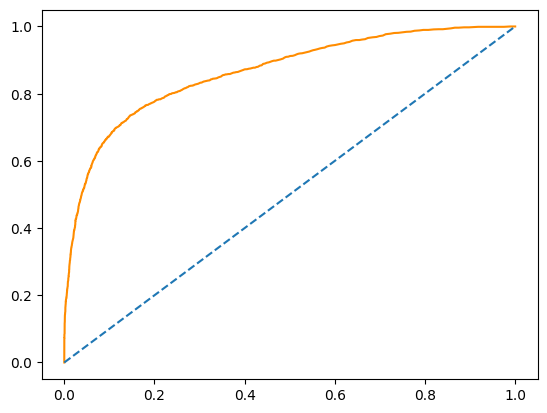

In [55]:
# Plot the ROC curve of the probabilities of default

fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [56]:
fallout.shape, sensitivity.shape, thresholds.shape

((900,), (900,), (900,))

In [57]:
[list(np.round((f,s,t), 3)) for f,s,t in zip(fallout, sensitivity, thresholds)][450:550]

[[0.055, 0.569, 0.465],
 [0.055, 0.571, 0.464],
 [0.056, 0.571, 0.463],
 [0.056, 0.572, 0.462],
 [0.056, 0.573, 0.461],
 [0.057, 0.574, 0.46],
 [0.057, 0.575, 0.459],
 [0.057, 0.576, 0.458],
 [0.057, 0.577, 0.457],
 [0.057, 0.577, 0.456],
 [0.058, 0.577, 0.455],
 [0.058, 0.578, 0.454],
 [0.059, 0.579, 0.453],
 [0.06, 0.58, 0.452],
 [0.06, 0.582, 0.45],
 [0.06, 0.582, 0.449],
 [0.06, 0.583, 0.448],
 [0.06, 0.585, 0.447],
 [0.06, 0.585, 0.446],
 [0.06, 0.587, 0.445],
 [0.061, 0.588, 0.444],
 [0.061, 0.589, 0.443],
 [0.061, 0.59, 0.442],
 [0.061, 0.591, 0.441],
 [0.062, 0.591, 0.44],
 [0.062, 0.592, 0.439],
 [0.062, 0.593, 0.438],
 [0.063, 0.595, 0.437],
 [0.063, 0.596, 0.436],
 [0.063, 0.596, 0.435],
 [0.063, 0.598, 0.434],
 [0.064, 0.599, 0.433],
 [0.064, 0.601, 0.432],
 [0.065, 0.602, 0.431],
 [0.065, 0.602, 0.43],
 [0.066, 0.603, 0.429],
 [0.066, 0.604, 0.428],
 [0.066, 0.606, 0.427],
 [0.066, 0.606, 0.426],
 [0.067, 0.606, 0.425],
 [0.067, 0.607, 0.424],
 [0.067, 0.608, 0.423],
 [0.0

In [58]:
# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
auc

0.8649851698154709

Thresholds and confusion matrices

You've looked at setting thresholds for defaults, but how does this impact overall performance? To do this, you can start by looking at the effects with confusion matrices.

Set different values for the threshold on probability of default, and use a confusion matrix to see how the changing values affect the model's performance.

In [59]:
# Print the confusion matrix (at 0.5 threshold)
print(confusion_matrix(y_test,preds_df['loan_status']))
print(classification_report(y_test,preds_df['loan_status']))

[[6551  330]
 [ 906 1051]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6881
           1       0.76      0.54      0.63      1957

    accuracy                           0.86      8838
   macro avg       0.82      0.74      0.77      8838
weighted avg       0.85      0.86      0.85      8838



In [60]:
# Set the threshold for defaults to 0.4
preds_df['loan_status_0.4'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)
preds_df

prob_default  loan_status  loan_status_0.4
0            0.181            0                0
1            0.039            0                0
2            0.058            0                0
3            0.322            0                0
4            0.257            0                0
...            ...          ...              ...
8833         0.481            0                1
8834         0.146            0                0
8835         0.926            1                1
8836         0.074            0                0
8837         0.278            0                0

[8838 rows x 3 columns]

In [61]:
# Print the confusion matrix
print(confusion_matrix(y_test,preds_df['loan_status_0.4']))
print(classification_report(y_test,preds_df['loan_status_0.4']))

[[6372  509]
 [ 731 1226]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      6881
           1       0.71      0.63      0.66      1957

    accuracy                           0.86      8838
   macro avg       0.80      0.78      0.79      8838
weighted avg       0.85      0.86      0.86      8838



How thresholds affect performance

Setting the threshold to 0.4 shows promising results for model evaluation. Now you can assess the financial impact using the default recall which is selected from the classification reporting using the function precision_recall_fscore_support().

For this, you will estimate the amount of unexpected loss using the default recall to find what proportion of defaults you did not catch with the new threshold. This will be a dollar amount which tells you how much in losses you would have if all the unfound defaults were to default all at once.

In [62]:
# Store the number of loan defaults from the prediction data
num_defaults = preds_df['loan_status_0.4'].value_counts()[1]
num_defaults

1735

In [63]:
# Store the default recall from the classification report
default_recall = recall_score(y_test, preds_df['loan_status_0.4'])
default_recall

0.6264690853346959

In [64]:
avg_loan_amnt = cr_loan.loan_amnt.mean()
avg_loan_amnt

9583.600936895346

In [65]:
# Calculate the estimated impact of the new default recall rate
print(avg_loan_amnt * num_defaults * (1 - default_recall))

6210903.073198935


Threshold selection

You know there is a trade off between metrics like default recall, non-default recall, and model accuracy. One easy way to approximate a good starting threshold value is to look at a plot of all three using matplotlib. With this graph, you can see how each of these metrics look as you change the threshold values and find the point at which the performance of all three is good enough to use for the credit data.

In [66]:
scores_by_thresh = {}

for thresh in np.round(np.arange(0, 1.01, 0.025),3):
    y_pred_thresh = preds_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    accuracy = accuracy_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, zero_division=1)  # or set it to 0 if you prefer
    recall_class_1 = recall_score(y_test, y_pred_thresh, pos_label=1)
    recall_class_0 = recall_score(y_test, y_pred_thresh, pos_label=0)
    scores_by_thresh[thresh] = list(np.round((accuracy, precision, recall_class_1, recall_class_0),3))

df_scores_by_thresh = pd.DataFrame(scores_by_thresh).T
df_scores_by_thresh.columns = ['accuracy', 'precision', 'recall_class_1', 'recall_class_0']
df_scores_by_thresh

accuracy  precision  recall_class_1  recall_class_0
0.000     0.222      0.221           1.000           0.000
0.025     0.392      0.265           0.987           0.223
0.050     0.530      0.313           0.942           0.413
0.075     0.607      0.350           0.901           0.524
0.100     0.669      0.389           0.866           0.612
0.125     0.714      0.426           0.840           0.678
0.150     0.752      0.465           0.816           0.733
0.175     0.777      0.497           0.795           0.771
0.200     0.796      0.527           0.775           0.802
0.225     0.810      0.552           0.759           0.825
0.250     0.823      0.578           0.740           0.846
0.275     0.834      0.606           0.716           0.867
0.300     0.843      0.631           0.700           0.883
0.325     0.848      0.650           0.682           0.896
0.350     0.854      0.672           0.665           0.908
0.375     0.857      0.690           0.643           0.918
0.400     0.860      0.707           0.626           0.926
0.425     0.861      0.722           0.606           0.934
0.450     0.861      0.735           0.581           0.940
0.475     0.862      0.751           0.561           0.947
0.500     0.860      0.761           0.537           0.952
0.525     0.860      0.776           0.517           0.958
0.550     0.858      0.791           0.491           0.963
0.575     0.857      0.806           0.467           0.968
0.600     0.854      0.811           0.444           0.971
0.625     0.853      0.828           0.427           0.975
0.650     0.849      0.830           0.400           0.977
0.675     0.845      0.841           0.370           0.980
0.700     0.842      0.862           0.340           0.984
0.725     0.839      0.868           0.320           0.986
0.750     0.835      0.876           0.295           0.988
0.775     0.830      0.879           0.268           0.990
0.800     0.825      0.894           0.237           0.992
0.825     0.820      0.907           0.211           0.994
0.850     0.817      0.930           0.190           0.996
0.875     0.813      0.950           0.164           0.998
0.900     0.807      0.966           0.131           0.999
0.925     0.799      0.974           0.096           0.999
0.950     0.794      1.000           0.068           1.000
0.975     0.787      1.000           0.038           1.000
1.000     0.779      1.000           0.000           1.000

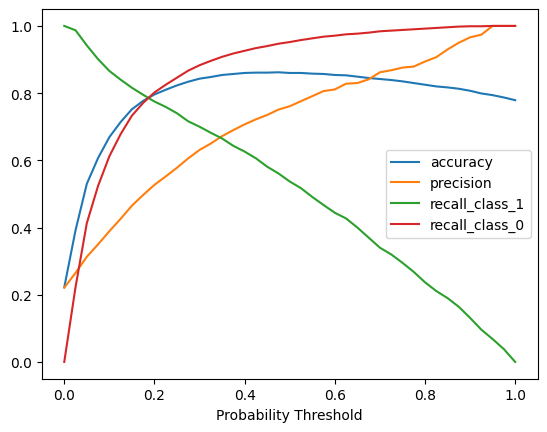

In [67]:
plt.plot(df_scores_by_thresh)
plt.xlabel("Probability Threshold")
plt.legend(df_scores_by_thresh.columns)

Trees for defaults

You will now train a gradient boosted tree model on the credit data, and see a sample of some of the predictions.

In [68]:
X_train

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
17598          21          23000                2.0       7000           8.90   
29323          39          21600                0.0       6000           6.03   
7484           26          53000                4.0       6800           9.91   
29158          44          12000                5.0       2000           9.88   
1092           21          24396                2.0       4000          15.05   
...           ...            ...                ...        ...            ...   
26399          29          40000                3.0      14150          12.69   
24791          33          78000                7.0      10000          13.06   
28732          33         125000                2.0      20000           7.88   
1087           24          72250                5.0      17600          17.19   
8992           24          46500                2.0       8000          15.23   

       loan_percent_income  cb_person_cred_hist_length  \
17598                 0.30                           4   
29323                 0.28                          12   
7484                  0.13                           4   
29158                 0.17                          11   
1092                  0.16                           4   
...                    ...                         ...   
26399                 0.35                           7   
24791                 0.13                           9   
28732                 0.16                           7   
1087                  0.21                           4   
8992                  0.17                           2   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
17598                            True                        False   
29323                           False                        False   
7484                            False                        False   
29158                           False                        False   
1092                             True                        False   
...                               ...                          ...   
26399                           False                        False   
24791                           False                        False   
28732                            True                        False   
1087                            False                        False   
8992                            False                        False   

       person_home_ownership_OWN  ...  loan_intent_VENTURE  loan_grade_A  \
17598                      False  ...                False          True   
29323                       True  ...                False          True   
7484                       False  ...                False         False   
29158                       True  ...                False         False   
1092                       False  ...                 True         False   
...                          ...  ...                  ...           ...   
26399                      False  ...                False         False   
24791                      False  ...                False         False   
28732                      False  ...                False          True   
1087                       False  ...                False         False   
8992                       False  ...                False         False   

       loan_grade_B  loan_grade_C  loan_grade_D  loan_grade_E  loan_grade_F  \
17598         False         False         False         False         False   
29323         False         False         False         False         False   
7484           True         False         False         False         False   
29158          True         False         False         False         False   
1092          False         False          True         False         False   
...             ...           ...           ...           ...           ...   
26399          True         Fa

In [69]:
# Train a model
clf_gbt = xgb.XGBClassifier().fit(X_train, y_train)
clf_gbt

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [70]:
# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)
gbt_preds

array([[0.9013869 , 0.09861311],
       [0.9315487 , 0.0684513 ],
       [0.9870248 , 0.0129752 ],
       ...,
       [0.85857904, 0.14142096],
       [0.94675004, 0.05324996],
       [0.8003917 , 0.19960836]], dtype=float32)

In [71]:
# Create dataframes of first five predictions, and first five true labels
gbt_preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['gbt_prob_default'])
gbt_true_df = y_test

# Concatenate and print the two data frames for comparison
portfolio = pd.concat([gbt_true_df.reset_index(drop = True), np.round(gbt_preds_df,3)], axis = 1)
portfolio

loan_status  gbt_prob_default
0               0             0.099
1               0             0.068
2               0             0.013
3               0             0.047
4               0             0.225
...           ...               ...
8833            0             0.515
8834            1             0.831
8835            1             0.141
8836            0             0.053
8837            1             0.200

[8838 rows x 2 columns]

Gradient boosted portfolio performance

At this point you've looked at predicting probability of default using both a LogisticRegression() and XGBClassifier(). You've looked at some scoring and have seen samples of the predictions, but what is the overall affect on portfolio performance? Try using expected loss as a scenario to express the importance of testing different models.

A data frame called portfolio has been created to combine the probabilities of default for both models, the loss given default (assume 20% for now), and the loan_amnt which will be assumed to be the exposure at default.

In [72]:
portfolio['lr_prob_default'] = preds_df['prob_default']
portfolio['loan_amnt'] = X_test.reset_index()['loan_amnt']
portfolio['lgd'] = 0.2
portfolio

loan_status  gbt_prob_default  lr_prob_default  loan_amnt  lgd
0               0             0.099            0.181      11500  0.2
1               0             0.068            0.039      11000  0.2
2               0             0.013            0.058      24000  0.2
3               0             0.047            0.322       9000  0.2
4               0             0.225            0.257      16000  0.2
...           ...               ...              ...        ...  ...
8833            0             0.515            0.481      12250  0.2
8834            1             0.831            0.146       3600  0.2
8835            1             0.141            0.926       7000  0.2
8836            0             0.053            0.074      20000  0.2
8837            1             0.200            0.278       7500  0.2

[8838 rows x 5 columns]

In [73]:
# Create expected loss columns for each model using the formula
portfolio['gbt_expected_loss'] = np.round(portfolio['gbt_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt'], 3)
portfolio['lr_expected_loss'] = np.round(portfolio['lr_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt'], 3)
portfolio

loan_status  gbt_prob_default  lr_prob_default  loan_amnt  lgd  \
0               0             0.099            0.181      11500  0.2   
1               0             0.068            0.039      11000  0.2   
2               0             0.013            0.058      24000  0.2   
3               0             0.047            0.322       9000  0.2   
4               0             0.225            0.257      16000  0.2   
...           ...               ...              ...        ...  ...   
8833            0             0.515            0.481      12250  0.2   
8834            1             0.831            0.146       3600  0.2   
8835            1             0.141            0.926       7000  0.2   
8836            0             0.053            0.074      20000  0.2   
8837            1             0.200            0.278       7500  0.2   

      gbt_expected_loss  lr_expected_loss  
0                227.70            416.30  
1                149.60             85.80  
2                 62.40            278.40  
3                 84.60            579.60  
4                720.00            822.40  
...                 ...               ...  
8833            1261.75           1178.45  
8834             598.32            105.12  
8835             197.40           1296.40  
8836             212.00            296.00  
8837             300.00            417.00  

[8838 rows x 7 columns]

In [74]:
# Print the sum of the expected loss for lr
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))

# Print the sum of the expected loss for gbt
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

LR expected loss:  4124428.105
GBT expected loss:  4058433.605


Assessing gradient boosted trees

So you've now used XGBClassifier() models to predict probability of default. These models can also use the .predict() method for creating predictions that give the actual class for loan_status.

You should check the model's initial performance by looking at the metrics from the classification_report(). Keep in mind that you have not set thresholds for these models yet.

In [75]:
# Predict the labels for loan status
gbt_preds = clf_gbt.predict(X_test)
gbt_preds

array([0, 0, 0, ..., 0, 0, 0])

In [76]:
# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      6881
     Default       0.96      0.72      0.82      1957

    accuracy                           0.93      8838
   macro avg       0.94      0.86      0.89      8838
weighted avg       0.93      0.93      0.93      8838



Column importance and default prediction

When using multiple training sets with many different groups of columns, it's important to keep and eye on which columns matter and which do not. It can be expensive or time-consuming to maintain a set of columns even though they might not have any impact on loan_status.

Train an XGBClassifier() model on this data, and check the column importance to see how each one performs to predict loan_status.

In [77]:
X = cr_loan_prep[['person_income','loan_int_rate',
                  'loan_percent_income','loan_amnt',
                  'person_home_ownership_MORTGAGE','loan_grade_F']]

X

person_income  loan_int_rate  loan_percent_income  loan_amnt  \
1               9600          11.14                 0.10       1000   
2               9600          12.87                 0.57       5500   
3              65500          15.23                 0.53      35000   
4              54400          14.27                 0.55      35000   
5               9900           7.14                 0.25       2500   
...              ...            ...                  ...        ...   
32576          53000          13.16                 0.11       5800   
32577         120000           7.49                 0.15      17625   
32578          76000          10.99                 0.46      35000   
32579         150000          11.48                 0.10      15000   
32580          42000           9.99                 0.15       6475   

       person_home_ownership_MORTGAGE  loan_grade_F  
1                               False         False  
2                                True         False  
3                               False         False  
4                               False         False  
5                               False         False  
...                               ...           ...  
32576                            True         False  
32577                            True         False  
32578                           False         False  
32579                            True         False  
32580                           False         False  

[29459 rows x 6 columns]

In [78]:
y

1        0
2        1
3        1
4        1
5        1
        ..
32576    0
32577    0
32578    1
32579    0
32580    0
Name: loan_status, Length: 29459, dtype: int64

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=333)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22094, 6), (7365, 6), (22094,), (7365,))

In [80]:
# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train, y_train)
clf_gbt

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [81]:
# Print the column importances from the model
clf_gbt.get_booster().get_score(importance_type = 'weight')

# 'weight' importance type is the number of times a feature is used to split the data across all trees.
# All options:
# Weight: Frequency of use.
# Gain: Average impact on performance.
# Cover: Number of observations affected.

{'person_income': 1153.0,
 'loan_int_rate': 1217.0,
 'loan_percent_income': 717.0,
 'loan_amnt': 654.0,
 'person_home_ownership_MORTGAGE': 166.0,
 'loan_grade_F': 15.0}

Visualizing column importance

When the model is trained on different sets of columns it changes the performance, but does the importance for the same column change depending on which group it's in?

In [82]:
X2 = cr_loan_prep[['loan_int_rate','person_emp_length']]
X3 = cr_loan_prep[['person_income','loan_int_rate','loan_percent_income']]

In [83]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.25, random_state=333)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=.25, random_state=333)

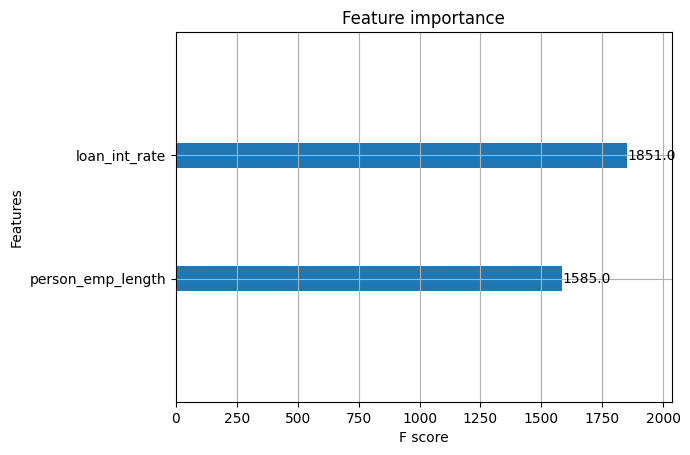

In [84]:
# Train a model on the X data with 2 columns
clf_gbt2 = xgb.XGBClassifier().fit(X2_train, y_train)

# Plot the column importance for this model
xgb.plot_importance(clf_gbt2, importance_type = 'weight')
plt.show()

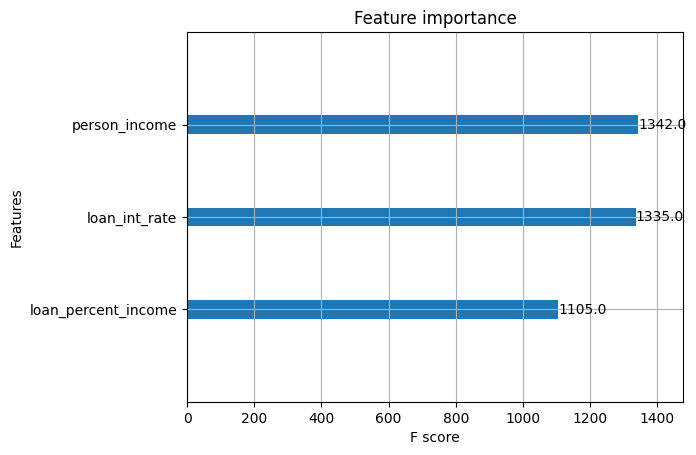

In [85]:
# Train a model on the X data with 3 columns
clf_gbt3 = xgb.XGBClassifier().fit(X3_train,y_train)

# Plot the column importance for this model
xgb.plot_importance(clf_gbt3, importance_type = 'weight')
plt.show()

Column selection and model performance

Creating the training set from different combinations of columns affects the model and the importance values of the columns. Does a different selection of columns also affect the F-1 scores, the combination of the precision and recall, of the model? You can answer this question by training two different models on two different sets of columns, and checking the performance.

Inaccurately predicting defaults as non-default can result in unexpected losses if the probability of default for these loans was very low. You can use the F-1 score for defaults to see how the models will accurately predict the defaults.

In [86]:
# Predict the loan_status using each model
gbt_preds = clf_gbt.predict(X_test)
gbt2_preds = clf_gbt2.predict(X2_test)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.91      0.96      0.93      5749
     Default       0.81      0.64      0.72      1616

    accuracy                           0.89      7365
   macro avg       0.86      0.80      0.82      7365
weighted avg       0.88      0.89      0.88      7365



In [87]:
# Print the classification report of the second model
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.83      0.96      0.89      5749
     Default       0.67      0.30      0.41      1616

    accuracy                           0.81      7365
   macro avg       0.75      0.63      0.65      7365
weighted avg       0.79      0.81      0.78      7365



Cross validating credit models

Credit loans and their data change over time, and it won't always look like what's been loaded into the current test sets. So, you can use cross-validation to try several smaller training and test sets which are derived from the original X_train and y_train.

Use the XGBoost function cv() to perform cross-validation. You will need to set up all the parameters for cv() to use on the test data.

In [88]:
params = {'objective': 'binary:logistic', 'seed': 123, 'eval_metric': 'auc'}

In [89]:
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

In [90]:
# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)
DTrain

In [91]:
# Create the data frame of cross validations
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
            early_stopping_rounds=early_stopping)

cv_df

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.885209       0.001262       0.875810      0.007218
1        0.891121       0.001445       0.883086      0.005693
2        0.893389       0.001409       0.885640      0.005328
3        0.895038       0.001516       0.886516      0.005669
4        0.897661       0.001409       0.887545      0.005268

Limits to cross-validation testing

You can specify very large numbers for both nfold and num_boost_round if you want to perform an extreme amount of cross-validation. The data frame cv_results_big has already been loaded in the workspace and was created with the following code:

Here, cv() performed 600 iterations of cross-validation! The parameter shuffle tells the function to shuffle the records each time.

Have a look at this data to see what the AUC are, and check to see if they reach 1.0 using cross validation. You should also plot the test AUC score to see the progression.

In [92]:
cv_results_big = xgb.cv(params, DTrain, num_boost_round = 300, nfold=10, shuffle = True)
cv_results_big

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.883632       0.001530       0.877123      0.006721
1          0.891111       0.000916       0.884619      0.005832
2          0.893366       0.000931       0.886526      0.005001
3          0.894870       0.000981       0.887651      0.005106
4          0.896923       0.001159       0.888518      0.004923
..              ...            ...            ...           ...
295        0.989234       0.000301       0.902892      0.007842
296        0.989306       0.000321       0.902868      0.007817
297        0.989354       0.000313       0.902843      0.007846
298        0.989400       0.000311       0.902823      0.007838
299        0.989424       0.000314       0.902849      0.007854

[300 rows x 4 columns]

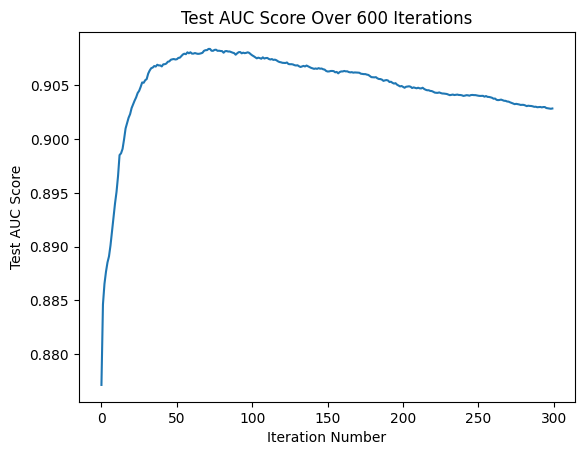

In [93]:
# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

 # Notice that the test AUC score never quite reaches 1.0 and begins to decrease after 100 iterations. 
# This is because this much cross-validation can actually cause the model to become overfit. So, there is a limit to how much cross-validation you should to.

Cross-validation scoring

Now, you should use cross-validation scoring with cross_val_score() to check the overall performance.

This is exercise presents an excellent opportunity to test out the use of the hyperparameters learning_rate and max_depth. Remember, hyperparameters are like settings which can help create optimum performance.

In [94]:
# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)
gbt

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [95]:
# Calculate the cross-validation scores for 4 folds
cv_scores = cross_val_score(gbt, X_train, y_train, cv=4)
cv_scores

array([0.88215062, 0.88196959, 0.89263082, 0.88774217])

In [96]:
# Print the average accuracy and standard deviation of the scores
# The * 2 is used to approximate the 95% confidence interval (± 2 standard deviations)
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Average accuracy: 0.89 (+/- 0.01)


Undersampling training data

It's time to undersample the training set yourself with a few lines of code from Pandas. Once the undersampling is complete, you can check the value counts for loan_status to verify the results.

In [97]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)

X_y_train

person_income  loan_int_rate  loan_percent_income  loan_amnt  \
0              60000           7.88                 0.23      14000   
1              99996          14.22                 0.20      20000   
2              87000           5.79                 0.09       8000   
3              55000          13.49                 0.08       4500   
4              83000          11.97                 0.16      13000   
...              ...            ...                  ...        ...   
22089          40000          12.69                 0.35      14150   
22090          78000          13.06                 0.13      10000   
22091         125000           7.88                 0.16      20000   
22092          72250          17.19                 0.21      17600   
22093          46500          15.23                 0.17       8000   

       person_home_ownership_MORTGAGE  loan_grade_F  loan_status  
0                               False         False            0  
1                               False         False            0  
2                                True         False            0  
3                               False         False            0  
4                                True         False            0  
...                               ...           ...          ...  
22089                           False         False            1  
22090                           False         False            1  
22091                            True         False            0  
22092                           False         False            1  
22093                           False         False            1  

[22094 rows x 7 columns]

In [98]:
count_nondefault, count_default = X_y_train['loan_status'].value_counts()
count_nondefault, count_default

(17247, 4847)

In [99]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train [X_y_train ['loan_status'] == 0]
defaults = X_y_train [X_y_train ['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)
nondefaults_under

person_income  loan_int_rate  loan_percent_income  loan_amnt  \
8839           42500          12.98                 0.12       5000   
20167          95000          16.49                 0.11      10000   
10831          57600          10.25                 0.26      15000   
16318          45888           5.79                 0.20       9000   
19549          40000           6.17                 0.13       5000   
...              ...            ...                  ...        ...   
3332          113800           8.63                 0.07       7500   
2746          120000          13.06                 0.05       6000   
17577         105000           6.54                 0.19      20000   
9619           30000           9.99                 0.23       7000   
20086          30000           6.62                 0.47      14125   

       person_home_ownership_MORTGAGE  loan_grade_F  loan_status  
8839                            False         False            0  
20167                           False         False            0  
10831                            True         False            0  
16318                           False         False            0  
19549                           False         False            0  
...                               ...           ...          ...  
3332                             True         False            0  
2746                             True         False            0  
17577                            True         False            0  
9619                            False         False            0  
20086                           False         False            0  

[4847 rows x 7 columns]

In [100]:
# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
X_y_train_under['loan_status'].value_counts()

loan_status
0    4847
1    4847
Name: count, dtype: int64

Undersampled tree performance

You've undersampled the training set and trained a model on the undersampled set.

The performance of the model's predictions not only impact the probability of default on the test set, but also on the scoring of new loan applications as they come in. You also now know that it is even more important that the recall of defaults be high, because a default predicted as non-default is more costly.

The next crucial step is to compare the new model's performance to the original model. The original predictions are stored as gbt_preds and the new model's predictions stored as gbt_preds_under.

In [101]:
X_train_under = X_y_train_under.drop('loan_status', axis=1)
X_train_under

person_income  loan_int_rate  loan_percent_income  loan_amnt  \
0             42500          12.98                 0.12       5000   
1             95000          16.49                 0.11      10000   
2             57600          10.25                 0.26      15000   
3             45888           5.79                 0.20       9000   
4             40000           6.17                 0.13       5000   
...             ...            ...                  ...        ...   
4842          50000          14.91                 0.30      15000   
4843          40000          12.69                 0.35      14150   
4844          78000          13.06                 0.13      10000   
4845          72250          17.19                 0.21      17600   
4846          46500          15.23                 0.17       8000   

      person_home_ownership_MORTGAGE  loan_grade_F  
0                              False         False  
1                              False         False  
2                               True         False  
3                              False         False  
4                              False         False  
...                              ...           ...  
4842                           False         False  
4843                           False         False  
4844                           False         False  
4845                           False         False  
4846                           False         False  

[9694 rows x 6 columns]

In [102]:
y_train_under = X_y_train_under['loan_status']
y_train_under

0       0
1       0
2       0
3       0
4       0
       ..
4842    1
4843    1
4844    1
4845    1
4846    1
Name: loan_status, Length: 9694, dtype: int64

In [103]:
clf_gbt_under = xgb.XGBClassifier().fit(X_train_under, y_train_under)
clf_gbt_under

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [104]:
# Predict the loan_status using each model
gbt_preds_under = clf_gbt_under.predict(X_test)
gbt_preds_under

array([1, 0, 1, ..., 0, 0, 0])

In [105]:
# Predict the loan_status using each model
gbt_preds_prob_under = clf_gbt_under.predict_proba(X_test)
gbt_preds_prob_under

array([[0.46397746, 0.53602254],
       [0.96996087, 0.03003913],
       [0.38760865, 0.61239135],
       ...,
       [0.6998979 , 0.30010208],
       [0.909255  , 0.09074497],
       [0.74912953, 0.2508705 ]], dtype=float32)

In [106]:
# Check the classification reports
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.91      0.96      0.93      5749
     Default       0.81      0.64      0.72      1616

    accuracy                           0.89      7365
   macro avg       0.86      0.80      0.82      7365
weighted avg       0.88      0.89      0.88      7365



In [107]:
print(classification_report(y_test, gbt_preds_under, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.94      0.85      0.89      5749
     Default       0.60      0.80      0.68      1616

    accuracy                           0.84      7365
   macro avg       0.77      0.82      0.79      7365
weighted avg       0.86      0.84      0.85      7365



In [108]:
# Print the confusion matrix for both old and new models
print(confusion_matrix(y_test,gbt_preds))

[[5500  249]
 [ 574 1042]]


In [109]:
print(confusion_matrix(y_test,gbt_preds_under))

[[4884  865]
 [ 325 1291]]


In [110]:
# Print and compare the AUC scores of the old and new models
print(roc_auc_score(y_test,gbt_preds))

0.8007450499355032


In [111]:
print(roc_auc_score(y_test,gbt_preds_under))

0.8242125944417367


Undersampling the training data results in more false positives, but the recall for defaults and the AUC score are both higher than the original model. 
This means overall it predicts defaults much more accurately.

Comparing model reports

You've used logistic regression models and gradient boosted trees. It's time to compare these two to see which model will be used to make the final predictions.

One of the easiest first steps for comparing different models' ability to predict the probability of default is to look at their metrics from the classification_report(). With this, you can see many different scoring metrics side-by-side for each model. Because the data and models are normally unbalanced with few defaults, focus on the metrics for defaults for now.

In [112]:
clf_logistic_under = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train_under, y_train_under)
clf_logistic_under

LogisticRegression(max_iter=1000)

In [113]:
# Predict the loan_status using each model
logistic_preds_under = clf_logistic_under.predict(X_test)
logistic_preds_under

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [114]:
# Predict the loan_status using each model
logistic_preds_prob_under = clf_logistic_under.predict_proba(X_test)
logistic_preds_prob_under

array([[0.54224429, 0.45775571],
       [0.90449323, 0.09550677],
       [0.57869688, 0.42130312],
       ...,
       [0.58220144, 0.41779856],
       [0.85284986, 0.14715014],
       [0.41249577, 0.58750423]])

In [115]:
print(classification_report(y_test, logistic_preds_under, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.92      0.76      0.83      5749
     Default       0.47      0.76      0.59      1616

    accuracy                           0.76      7365
   macro avg       0.70      0.76      0.71      7365
weighted avg       0.82      0.76      0.78      7365



In [116]:
# Print the macro F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test, logistic_preds_under, average = 'macro'))

(0.697125905535119, 0.7627812262657818, 0.7094846589904903, None)


In [117]:
# Print the macro F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test, gbt_preds_under, average = 'macro'))

(0.7682010246287733, 0.8242125944417367, 0.787960519070501, None)


Comparing with ROCs

You should use ROC charts and AUC scores to compare the two models. Sometimes, visuals can really help you and potential business users understand the differences between the various models under consideration.

With the graph in mind, you will be more equipped to make a decision. The lift is how far the curve is from the random prediction. The AUC is the area between the curve and the random prediction. The model with more lift, and a higher AUC, is the one that's better at making predictions accurately.

In [118]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, logistic_preds_prob_under[:,1])
fallout_lr, sensitivity_lr, thresholds_lr

(array([0.        , 0.        , 0.        , ..., 0.99965211, 0.99965211,
        1.        ]),
 array([0.00000000e+00, 6.18811881e-04, 7.42574257e-03, ...,
        9.99381188e-01, 1.00000000e+00, 1.00000000e+00]),
 array([       inf, 0.99828958, 0.99177689, ..., 0.0086058 , 0.00817771,
        0.00260687]))

In [119]:
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, gbt_preds_prob_under[:,1])
fallout_gbt, sensitivity_gbt, thresholds_gbt

(array([0.        , 0.        , 0.        , ..., 0.99617325, 0.99617325,
        1.        ]),
 array([0.00000000e+00, 6.18811881e-04, 2.78465347e-02, ...,
        9.99381188e-01, 1.00000000e+00, 1.00000000e+00]),
 array([       inf, 0.99980515, 0.99873716, ..., 0.00375056, 0.00365223,
        0.00167339], dtype=float32))

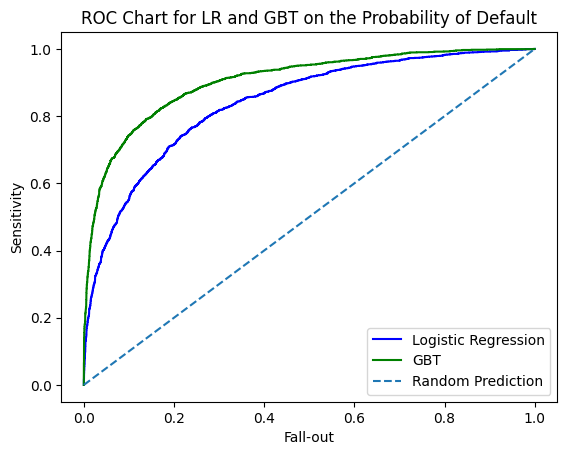

In [120]:
# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [121]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, logistic_preds_prob_under[:,1]))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, gbt_preds_prob_under[:,1]))

Logistic Regression AUC Score: 0.84
Gradient Boosted Tree AUC Score: 0.90


Calibration curves

You now know that the gradient boosted tree clf_gbt has the best overall performance. You need to check the calibration of the two models to see how stable the default prediction performance is across probabilities. You can use a chart of each model's calibration to check this by calling the calibration_curve() function.

In [122]:
# Calculate calibration curve for Logistic Regression
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, logistic_preds_prob_under[:,1], n_bins=16)
frac_of_pos_lr, mean_pred_val_lr

(array([0.01612903, 0.02690058, 0.04383562, 0.05503145, 0.08757962,
        0.12199313, 0.13114754, 0.18867925, 0.26008969, 0.29567308,
        0.36956522, 0.45054945, 0.53089888, 0.67625899, 0.82352941,
        0.90604027]),
 array([0.04616111, 0.09267562, 0.15567134, 0.21852534, 0.27957155,
        0.34280679, 0.40612566, 0.46641975, 0.53203325, 0.59277685,
        0.65503515, 0.71835987, 0.78020122, 0.84225749, 0.90454701,
        0.9640851 ]))

In [123]:
# Calculate calibration curve for Gradient Boosting Classifier
frac_of_pos_gbt, mean_pred_val_gbt = calibration_curve(y_test, gbt_preds_prob_under[:,1], n_bins=16)
frac_of_pos_gbt, mean_pred_val_gbt

(array([0.01512605, 0.04318618, 0.045961  , 0.06860707, 0.10843373,
        0.1590106 , 0.17813765, 0.22268908, 0.22790698, 0.25146199,
        0.36516854, 0.32768362, 0.49404762, 0.56976744, 0.68235294,
        0.87926829]),
 array([0.03083738, 0.09167409, 0.15526601, 0.21800113, 0.27960246,
        0.34331651, 0.40645198, 0.46720827, 0.53232387, 0.59460422,
        0.65752442, 0.71784676, 0.78104839, 0.84312505, 0.91045015,
        0.97837454]))

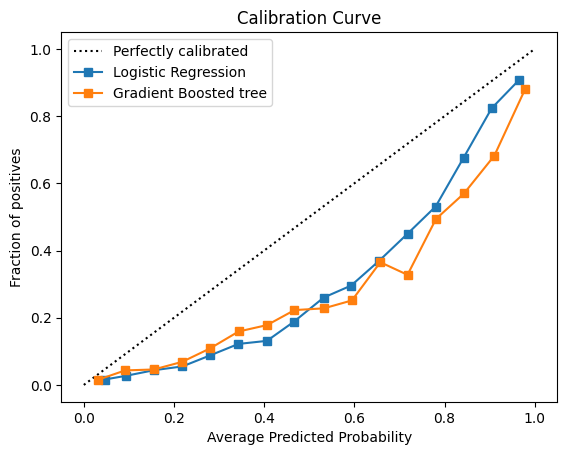

In [124]:
# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Acceptance rates

Setting an acceptance rate and calculating the threshold for that rate can be used to set the percentage of new loans you want to accept. For this exercise, assume the test data is a fresh batch of new loans. You will need to use the quantile() function from numpy to calculate the threshold.

The threshold should be used to assign new loan_status values. Does the number of defaults and non-defaults in the data change?

In [125]:
X_test

person_income  loan_int_rate  loan_percent_income  loan_amnt  \
31163          73000          12.21                 0.16      11500   
28109          82500           7.49                 0.13      11000   
11802          76000          10.99                 0.32      24000   
9844           38400           7.90                 0.23       9000   
22872          59000          13.98                 0.27      16000   
...              ...            ...                  ...        ...   
30833          78000          12.99                 0.12       9600   
13830          96000          11.83                 0.05       5000   
196           188000          17.74                 0.11      20000   
5075           43200           7.51                 0.14       6000   
16633          45000          13.98                 0.11       4800   

       person_home_ownership_MORTGAGE  loan_grade_F  
31163                           False         False  
28109                            True         False  
11802                            True         False  
9844                            False         False  
22872                            True         False  
...                               ...           ...  
30833                           False         False  
13830                            True         False  
196                              True         False  
5075                             True         False  
16633                           False         False  

[7365 rows x 6 columns]

In [126]:
test_pred_df = pd.DataFrame({
    'true_loan_status': y_test,
    'prob_default': gbt_preds_prob_under[:, 1],
    'loan_amnt': X_test.loan_amnt
})

test_pred_df

true_loan_status  prob_default  loan_amnt
31163                 0      0.536023      11500
28109                 0      0.030039      11000
11802                 0      0.612391      24000
9844                  0      0.114830       9000
22872                 0      0.899495      16000
...                 ...           ...        ...
30833                 0      0.602555       9600
13830                 0      0.053880       5000
196                   1      0.300102      20000
5075                  0      0.090745       6000
16633                 0      0.250870       4800

[7365 rows x 3 columns]

In [127]:
# Check the statistics of the probabilities of default
test_pred_df.describe()

true_loan_status  prob_default     loan_amnt
count       7365.000000   7365.000000   7365.000000
mean           0.219416      0.347941   9648.594705
std            0.413879      0.335820   6363.285204
min            0.000000      0.001673    500.000000
25%            0.000000      0.065608   5000.000000
50%            0.000000      0.204155   8000.000000
75%            0.000000      0.599750  12225.000000
max            1.000000      0.999805  35000.000000

In [128]:
# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(test_pred_df['prob_default'], 0.85)
threshold_85

0.8626333355903623

In [129]:
# Apply acceptance rate threshold
test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)
test_pred_df

true_loan_status  prob_default  loan_amnt  pred_loan_status
31163                 0      0.536023      11500                 0
28109                 0      0.030039      11000                 0
11802                 0      0.612391      24000                 0
9844                  0      0.114830       9000                 0
22872                 0      0.899495      16000                 1
...                 ...           ...        ...               ...
30833                 0      0.602555       9600                 0
13830                 0      0.053880       5000                 0
196                   1      0.300102      20000                 0
5075                  0      0.090745       6000                 0
16633                 0      0.250870       4800                 0

[7365 rows x 4 columns]

In [130]:
# Print the counts of loan status after the threshold
test_pred_df['pred_loan_status'].value_counts()

pred_loan_status
0    6260
1    1105
Name: count, dtype: int64

Visualizing quantiles of acceptance

You know how quantile() works to compute a threshold, and you've seen an example of what it does to split the loans into accepted and rejected. What does this threshold look like for the test set, and how can you visualize it?

To check this, you can create a histogram of the probabilities and add a reference line for the threshold. With this, you can visually show where the threshold exists in the distribution.

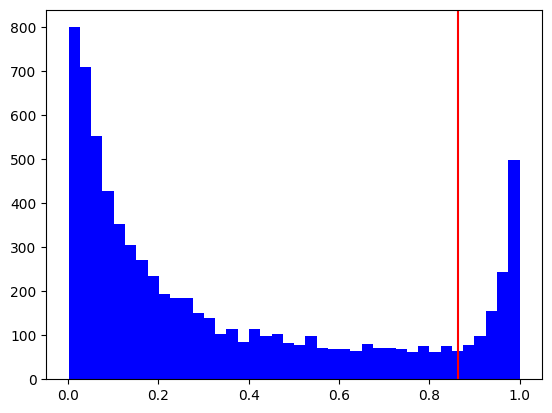

In [131]:
# Plot the predicted probabilities of default
plt.hist(gbt_preds_prob_under[:,1], color = 'blue', bins = 40)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold_85, color = 'red')
plt.show()

# it's possible to re-run this code with different threshold values to better understand how this affects the acceptance rate.

Bad rates

With acceptance rate in mind, you can now analyze the bad rate within the accepted loans. This way you will be able to see the percentage of defaults that have been accepted.

Think about the impact of the acceptance rate and bad rate. We set an acceptance rate to have fewer defaults in the portfolio because defaults are more costly. Will the bad rate be less than the percentage of defaults in the test data?

In [132]:
# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
accepted_loans

true_loan_status  prob_default  loan_amnt  pred_loan_status
31163                 0      0.536023      11500                 0
28109                 0      0.030039      11000                 0
11802                 0      0.612391      24000                 0
9844                  0      0.114830       9000                 0
23502                 0      0.032484       8400                 0
...                 ...           ...        ...               ...
30833                 0      0.602555       9600                 0
13830                 0      0.053880       5000                 0
196                   1      0.300102      20000                 0
5075                  0      0.090745       6000                 0
16633                 0      0.250870       4800                 0

[6260 rows x 4 columns]

In [133]:
# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / np.size(accepted_loans['true_loan_status']))

# This means that of all the loans we've decided to accept from the test set, only 11% were actual defaults! 
# If we accepted all loans, the percentage of defaults would be around 22%.

0.11230031948881788


Acceptance rate impact

Now, look at the loan_amnt of each loan to understand the impact on the portfolio for the acceptance rates. You can use cross tables with calculated values, like the average loan amount, of the new set of loans X_test. For this, you will multiply the number of each with an average loan_amnt value.

In [134]:
pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status'])

# the value correspondent to the pred_loan_status 0 and true_loan_status 1 are the predictions which make the bad rate

pred_loan_status     0    1
true_loan_status           
0                 5557  192
1                  703  913

In [135]:
# Store the average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])
avg_loan

9648.594704684318

In [136]:
# # Set the formatting for currency, and print the cross tab
# pd.options.display.float_format = '${:,.2f}'.format

print(pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

# the value correspondent to the pred_loan_status 0 and true_loan_status 1 are the losses due to the bad rate

pred_loan_status             0             1
true_loan_status                            
0                 5.361724e+07  1.852530e+06
1                 6.782962e+06  8.809167e+06


Making the strategy table

Before you implement a strategy, you should first create a strategy table containing all the possible acceptance rates you wish to look at along with their associated bad rates and threshold values. This way, you can begin to see each part of your strategy and how it affects your portfolio.

In [137]:
accept_rates = list(np.round(np.arange(0.05, 1.01, 0.05),2))[::-1]

accept_rates

[1.0,
 0.95,
 0.9,
 0.85,
 0.8,
 0.75,
 0.7,
 0.65,
 0.6,
 0.55,
 0.5,
 0.45,
 0.4,
 0.35,
 0.3,
 0.25,
 0.2,
 0.15,
 0.1,
 0.05]

In [138]:
aceptrate_thresh_aceptloans_badrate = {}

for rate in accept_rates:
  	# Calculate the threshold for the acceptance rate
    thresh = np.quantile(test_pred_df['prob_default'], rate).round(3)
    # Calculate the loan_status value at each acceptance rate, using the threshold
    test_pred_df[f'pred_loan_status_{rate}'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df[f'pred_loan_status_{rate}'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    n_accepted_loans = len(accepted_loans['true_loan_status'])
    bad_rate = np.sum((accepted_loans['true_loan_status']) / n_accepted_loans).round(3)
    aceptrate_thresh_aceptloans_badrate[rate] = [thresh, n_accepted_loans, bad_rate]

aceptrate_thresh_aceptloans_badrate

{1.0: [1.0, 7365, 0.219],
 0.95: [0.986, 7004, 0.182],
 0.9: [0.95, 6624, 0.144],
 0.85: [0.863, 6260, 0.112],
 0.8: [0.727, 5892, 0.089],
 0.75: [0.6, 5525, 0.072],
 0.7: [0.484, 5155, 0.06],
 0.65: [0.389, 4787, 0.05],
 0.6: [0.309, 4419, 0.041],
 0.55: [0.254, 4052, 0.034],
 0.5: [0.204, 3681, 0.031],
 0.45: [0.165, 3312, 0.028],
 0.4: [0.135, 2948, 0.026],
 0.35: [0.108, 2570, 0.024],
 0.3: [0.084, 2197, 0.021],
 0.25: [0.066, 1851, 0.016],
 0.2: [0.05, 1461, 0.011],
 0.15: [0.036, 1097, 0.011],
 0.1: [0.025, 749, 0.005],
 0.05: [0.014, 370, 0.003]}

In [139]:
test_pred_df.drop('pred_loan_status', axis=1, inplace=True)

test_pred_df

true_loan_status  prob_default  loan_amnt  pred_loan_status_1.0  \
31163                 0      0.536023      11500                     0   
28109                 0      0.030039      11000                     0   
11802                 0      0.612391      24000                     0   
9844                  0      0.114830       9000                     0   
22872                 0      0.899495      16000                     0   
...                 ...           ...        ...                   ...   
30833                 0      0.602555       9600                     0   
13830                 0      0.053880       5000                     0   
196                   1      0.300102      20000                     0   
5075                  0      0.090745       6000                     0   
16633                 0      0.250870       4800                     0   

       pred_loan_status_0.95  pred_loan_status_0.9  pred_loan_status_0.85  \
31163                      0                     0                      0   
28109                      0                     0                      0   
11802                      0                     0                      0   
9844                       0                     0                      0   
22872                      0                     0                      1   
...                      ...                   ...                    ...   
30833                      0                     0                      0   
13830                      0                     0                      0   
196                        0                     0                      0   
5075                       0                     0                      0   
16633                      0                     0                      0   

       pred_loan_status_0.8  pred_loan_status_0.75  pred_loan_status_0.7  ...  \
31163                     0                      0                     1  ...   
28109                     0                      0                     0  ...   
11802                     0                      1                     1  ...   
9844                      0                      0                     0  ...   
22872                     1                      1                     1  ...   
...                     ...                    ...                   ...  ...   
30833                     0                      1                     1  ...   
13830                     0                      0                     0  ...   
196                       0                      0                     0  ...   
5075                      0                      0                     0  ...   
16633                     0                      0                     0  ...   

       pred_loan_status_0.5  pred_loan_status_0.45  pred_loan_status_0.4  \
31163                     1                      1                     1   
28109                     0                      0                     0   
11802                     1                      1                     1   
9844                      0                      0                     0   
22872                     1                      1                     1   
...                     ...                    ...                   ...   
30833                     1                      1                     1   
13830                     0                      0                     0   
196                       1                      1                     1   
5075                      0                      0                     0   
16633                     1                      1                     1   

       pred_loan_status_0.35  pred_loan_status_0.3  pred_loan_status_0.25  \
31163                      1                     1                      1   
28109                      0                     0                      0   
11802                      1                     1                      1   

In [141]:
strat_df = pd.DataFrame(aceptrate_thresh_aceptloans_badrate).T.reset_index()
strat_df.columns = ['Acceptance Rate','Threshold','Num Accepted Loans','Bad Rate']
strat_df['Avg Loan Amnt'] = avg_loan.round(2)
strat_df['Estimated Value'] = ((strat_df['Num Accepted Loans'] * (1 - strat_df['Bad Rate'])) * strat_df['Avg Loan Amnt']) - (strat_df['Num Accepted Loans'] * strat_df['Bad Rate'] * strat_df['Avg Loan Amnt'])
strat_df

# Num Accepted Loans:	The number of accepted loans based on the threshold
# Avg Loan Amnt:	The average loan amount of the entire test set
# Estimated value:	The estimated net value of non-defaults minus defaults

Acceptance Rate  Threshold  Num Accepted Loans  Bad Rate  Avg Loan Amnt  \
0              1.00      1.000              7365.0     0.219        9648.59   
1              0.95      0.986              7004.0     0.182        9648.59   
2              0.90      0.950              6624.0     0.144        9648.59   
3              0.85      0.863              6260.0     0.112        9648.59   
4              0.80      0.727              5892.0     0.089        9648.59   
5              0.75      0.600              5525.0     0.072        9648.59   
6              0.70      0.484              5155.0     0.060        9648.59   
7              0.65      0.389              4787.0     0.050        9648.59   
8              0.60      0.309              4419.0     0.041        9648.59   
9              0.55      0.254              4052.0     0.034        9648.59   
10             0.50      0.204              3681.0     0.031        9648.59   
11             0.45      0.165              3312.0     0.028        9648.59   
12             0.40      0.135              2948.0     0.026        9648.59   
13             0.35      0.108              2570.0     0.024        9648.59   
14             0.30      0.084              2197.0     0.021        9648.59   
15             0.25      0.066              1851.0     0.016        9648.59   
16             0.20      0.050              1461.0     0.011        9648.59   
17             0.15      0.036              1097.0     0.011        9648.59   
18             0.10      0.025               749.0     0.005        9648.59   
19             0.05      0.014               370.0     0.003        9648.59   

    Estimated Value  
0      3.993677e+07  
1      4.298007e+07  
2      4.550553e+07  
3      4.687053e+07  
4      4.673028e+07  
5      4.563204e+07  
6      4.376986e+07  
7      4.156902e+07  
8      3.914088e+07  
9      3.643755e+07  
10     3.331444e+07  
11     3.016659e+07  
12     2.696495e+07  
13     2.360663e+07  
14     2.030764e+07  
15     1.728803e+07  
16     1.378647e+07  
17     1.035164e+07  
18     7.154526e+06  
19     3.548558e+06

Visualizing the strategy

Now you have the extended strategy table strat_df. The table is not so big that it's difficult to analyze, but visuals can help you see the overview all at once.

You should check at the distribution of each column with a box plot. If the distribution of Acceptance Rate looks the same as the Bad Rate column, that could be a problem. That means that the model's calibration is likely much worse than you thought.

You can also visualize the strategy curve with a line plot. The Acceptance Rate would be the independent variable with the Bad Rate as the dependent variable.

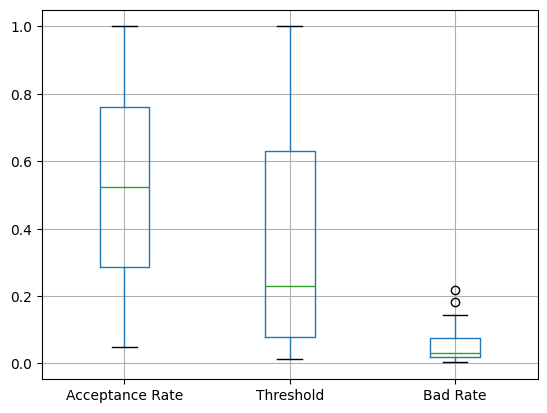

In [142]:
# Visualize the distributions in the strategy table with a boxplot
strat_df[['Acceptance Rate','Threshold','Bad Rate']].boxplot()
plt.show()

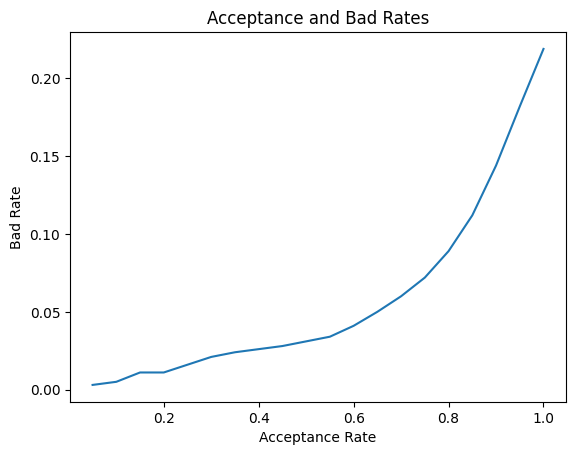

In [143]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.show()

# The bad rates are very low up until the acceptance rate 0.6 where they suddenly increase. 
# This suggests that many of the accepted defaults may have a prob_default value between 0.6 and 0.8

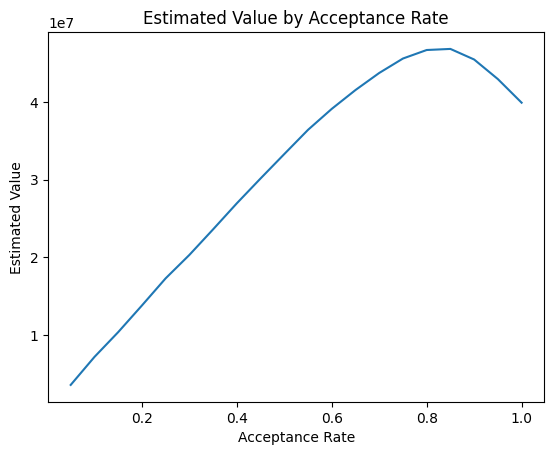

In [144]:
# Create a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'],strat_df['Estimated Value'])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.show()

In [145]:
# Print the row with the max estimated value
strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])]

Acceptance Rate  Threshold  Num Accepted Loans  Bad Rate  Avg Loan Amnt  \
3             0.85      0.863              6260.0     0.112        9648.59   

   Estimated Value  
3     4.687053e+07

Total expected loss

It's time to estimate the total expected loss given all your decisions. The data frame test_pred_df has the probability of default for each loan and that loan's value. Use these two values to calculate the expected loss for each loan. Then, you can sum those values and get the total expected loss.

Total Expected Loss = sum(prob_default * loss_given_default * loan_amnt)

For this exercise, you will assume that the exposure is the full value of the loan, and the loss given default is 100%. This means that a default on each the loan is a loss of the entire amount.

In [147]:
test_pred_df['loss_given_default'] = 1
# Calculate the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loan_amnt'] * test_pred_df['loss_given_default']

test_pred_df

true_loan_status  prob_default  loan_amnt  pred_loan_status_1.0  \
31163                 0      0.536023      11500                     0   
28109                 0      0.030039      11000                     0   
11802                 0      0.612391      24000                     0   
9844                  0      0.114830       9000                     0   
22872                 0      0.899495      16000                     0   
...                 ...           ...        ...                   ...   
30833                 0      0.602555       9600                     0   
13830                 0      0.053880       5000                     0   
196                   1      0.300102      20000                     0   
5075                  0      0.090745       6000                     0   
16633                 0      0.250870       4800                     0   

       pred_loan_status_0.95  pred_loan_status_0.9  pred_loan_status_0.85  \
31163                      0                     0                      0   
28109                      0                     0                      0   
11802                      0                     0                      0   
9844                       0                     0                      0   
22872                      0                     0                      1   
...                      ...                   ...                    ...   
30833                      0                     0                      0   
13830                      0                     0                      0   
196                        0                     0                      0   
5075                       0                     0                      0   
16633                      0                     0                      0   

       pred_loan_status_0.8  pred_loan_status_0.75  pred_loan_status_0.7  ...  \
31163                     0                      0                     1  ...   
28109                     0                      0                     0  ...   
11802                     0                      1                     1  ...   
9844                      0                      0                     0  ...   
22872                     1                      1                     1  ...   
...                     ...                    ...                   ...  ...   
30833                     0                      1                     1  ...   
13830                     0                      0                     0  ...   
196                       0                      0                     0  ...   
5075                      0                      0                     0  ...   
16633                     0                      0                     0  ...   

       pred_loan_status_0.4  pred_loan_status_0.35  pred_loan_status_0.3  \
31163                     1                      1                     1   
28109                     0                      0                     0   
11802                     1                      1                     1   
9844                      0                      1                     1   
22872                     1                      1                     1   
...                     ...                    ...                   ...   
30833                     1                      1                     1   
13830                     0                      0                     0   
196                       1                      1                     1   
5075                      0                      0                     1   
16633                     1                      1                     1   

       pred_loan_status_0.25  pred_loan_status_0.2  pred_loan_status_0.15  \
31163                      1                     1                      1   
28109                      0                     0                      0   
11802                      1                     1                      1   

In [148]:
# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

Total expected loss:  $26,169,604.03
